|path|filename|title|author|creator|subject|numPages|numberofWords|language|abstract|conclusion|references|publisher|researchpublication|
|-|-|-|-|-|-|-|-|-|-|-|-|-|-|
|path to file|file name|binary|binary|binary|categorical|numeric|numeric|category|binary|binary|binary|categorical|binary(y)|

In [8]:
import pandas as pd
import numpy as np
import pprint
import PyPDF2
import pdfminer
import os
import glob
import random

In [9]:
from langdetect import detect
from langdetect import detect_langs

# Create Final Project PDF files

In [10]:
def randomFiles(location):
    randomFilesDF = pd.DataFrame()
    for i in location:
        pdffiles = sorted(glob.glob(i + '*.pdf'))
        pdffiles = pd.DataFrame({'filePath' : pdffiles})
        result = pdffiles.sample(40,  random_state = np.random.RandomState(10))
        randomFilesDF = pd.concat([randomFilesDF, result])
    return randomFilesDF

In [11]:
randomFilesDF = randomFiles(["/scratch/yte9pc/InternetArchive/Datasets/fatcat_longtail_lang/", 
             "/scratch/yte9pc/InternetArchive/Datasets/fatcat_pdf/",
             "/scratch/yte9pc/InternetArchive/Datasets/gwb_random_pdf/"])

In [12]:
randomFilesDF.to_csv('BayesProject_PDFs.csv')

# Parse through files

In [13]:
class ParsePDF:
    def __init__(self, pdf):
        self.pdf = pdf
        self.fileName = None
        self.pdfFileObj = None
        self.pdfReader = None
        self.information = None
        self.outline = None
        
        self.numPages = None
        self.title = None
        self.author = None
        self.creator = None
        self.subject = None
        self.text = {}
        self.parsable = None
    
    def getText(self):
        for page in range(self.numPages):
            pageObj = self.pdfReader.getPage(page)
            self.text[page] = pageObj.extractText().replace('\n', ' ')
        return self.text
    
    def parsePDF(self):
        self.fileName = self.pdf.split('/')[-1]
        
        # Open the PDF
        self.pdfFileObj = open(self.pdf, 'rb')
        
        try:
            # PyPDF2 Object
            self.pdfReader = PyPDF2.PdfFileReader(self.pdfFileObj)
            self.information = self.pdfReader.getDocumentInfo()
            self.outline = self.pdfReader.getOutlines()
            self.title = self.information.title
            self.author = self.information.author
            self.creator = self.information.creator
            self.subject = self.information.subject
            
            # Checks if Encrypted
            if self.pdfReader.isEncrypted == False:
                try:
                    self.numPages = self.pdfReader.numPages
                    #print(self.numpages)
                    self.text = self.getText()
                    self.parsable = True
                    
                except Exception:
                    self.numPages = np.nan
                    self.parsable = False
                    
            else: # Encrypted PDFs
                self.numPages = np.nan
                self.parsable = False
                
        except Exception: # Corrupted PDFs
            self.numPages = np.nan
            self.parsable = False
            
        self.pdfFileObj.close()
    
    def getPDF(self):
        return self.pdf
    
    def getFileName(self):
        return self.fileName
    
    def getParsable(self):
        return self.parsable
    
    def getNumPages(self):
        return self.numPages
    
    def getTitle(self):
        return self.title
    
    def getAuthor(self):
        return self.author
    
    def getCreator(self):
        return self.creator
    
    def getSubject(self):
        return self.subject
    
    def getAllText(self):
        return self.text
    
    def getPageText(self, pageNum):
        return self.text.get(pageNum)

In [14]:
def metaData(PDFs):
    file, fileName, parsable, numPages, title, author, creator, subject = [], [], [], [], [], [], [], []
    
    for pdf in PDFs:
        p = ParsePDF(pdf)
        p.parsePDF()
        file.append(p.getPDF())
        fileName.append(p.getFileName())
        parsable.append(p.getParsable())
        numPages.append(p.getNumPages())
        title.append(p.getTitle())
        author.append(p.getAuthor())
        creator.append(p.getCreator())
        subject.append(p.getSubject())
        
        
    metaData = pd.DataFrame({'file' : file, 'fileName' : fileName, 'parsable' : parsable, 'numPages' : numPages, 'title' : title, 
                       'author' : author, 'creator' : creator, 'subject' : subject})
    return metaData

In [15]:
%time meta = metaData(randomFilesDF.filePath.values)
meta

CPU times: user 48.5 s, sys: 507 ms, total: 49.1 s
Wall time: 1min 10s


,file,fileName,parsable,numPages,title,author,creator,subject
0,/scratch/yte9pc/InternetArchive/Datasets/fatca...,1803702a5f55bedac6ee2e260eac5a91a06f5faf.pdf,True,2.0,36. Praca z oddechem w psychoterapii pacjentów...,A. Heyda,Elsevier,"Reports of Practical Oncology Radiotherapy, 8..."
1,/scratch/yte9pc/InternetArchive/Datasets/fatca...,ee22c7b06a7c4790d6fac7c1989d6af5a5e98047.pdf,True,10.0,<32372D3120C1A4BDC5B0A3C8A320B3EDB9AE2DC3D6C1B...,Administrator,PScript5.dll Version 5.2.2,None
2,/scratch/yte9pc/InternetArchive/Datasets/fatca...,393f69519f68c7f9b6c1b648db2c743e425898c5.pdf,True,14.0,None,None,Adobe Acrobat 7.0,None
3,/scratch/yte9pc/InternetArchive/Datasets/fatca...,0477fcf60f4dcf335a576850a6bbb3ad695d910e.pdf,True,4.0,020-06-17(이상엽-김혜영)_282~285.hwp,<B1E8C1BEC3B6>,PScript5.dll Version 5.2,None
4,/scratch/yte9pc/InternetArchive/Datasets/fatca...,dd0b88773368f85bb889eabcd93cc0044290f9c3.pdf,True,4.0,L09-21--D-MED-3.fm,JM,PScript5.dll Version 5.2.2,None
...,...,...,...,...,...,...,...,...
115,/scratch/yte9pc/InternetArchive/Datasets/gwb_r...,0000bc52ac29efe0cc87e8104c5441df67ad1644.pdf,False,NaN,None,None,None,None
116,/scratch/yte9pc/InternetArchive/Datasets/gwb_r...,0000393f59709e7d79b88aeeeb75e8ef32c25a22.pdf,True,4.0,FREE CPC EXAM STUDY GUIDE PDF-6FCESG6ANUS,None,Adobe Acrobat,None
117,/scratch/yte9pc/InternetArchive/Datasets/gwb_r...,00000c189fe2281d8b8e15488f547cab3eaaeba1.pdf,True,2.0,None,None,"R and OS php pdf writer, http://www.ros.co.nz",None
118,/scratch/yte9pc/InternetArchive/Datasets/gwb_r...,0000cacfc7f11918f52c013a38eff0d0578dda05.pdf,True,2.0,None,None,Crystal Reports,None


In [16]:
meta.query("parsable == True")

,file,fileName,parsable,numPages,title,author,creator,subject
0,/scratch/yte9pc/InternetArchive/Datasets/fatca...,1803702a5f55bedac6ee2e260eac5a91a06f5faf.pdf,True,2.0,36. Praca z oddechem w psychoterapii pacjentów...,A. Heyda,Elsevier,"Reports of Practical Oncology Radiotherapy, 8..."
1,/scratch/yte9pc/InternetArchive/Datasets/fatca...,ee22c7b06a7c4790d6fac7c1989d6af5a5e98047.pdf,True,10.0,<32372D3120C1A4BDC5B0A3C8A320B3EDB9AE2DC3D6C1B...,Administrator,PScript5.dll Version 5.2.2,None
2,/scratch/yte9pc/InternetArchive/Datasets/fatca...,393f69519f68c7f9b6c1b648db2c743e425898c5.pdf,True,14.0,None,None,Adobe Acrobat 7.0,None
3,/scratch/yte9pc/InternetArchive/Datasets/fatca...,0477fcf60f4dcf335a576850a6bbb3ad695d910e.pdf,True,4.0,020-06-17(이상엽-김혜영)_282~285.hwp,<B1E8C1BEC3B6>,PScript5.dll Version 5.2,None
4,/scratch/yte9pc/InternetArchive/Datasets/fatca...,dd0b88773368f85bb889eabcd93cc0044290f9c3.pdf,True,4.0,L09-21--D-MED-3.fm,JM,PScript5.dll Version 5.2.2,None
...,...,...,...,...,...,...,...,...
114,/scratch/yte9pc/InternetArchive/Datasets/gwb_r...,00009021c324294685af83856676dadfe61fb064.pdf,True,1.0,None,None,HP PDF Formatter version 3.2.0.539,None
116,/scratch/yte9pc/InternetArchive/Datasets/gwb_r...,0000393f59709e7d79b88aeeeb75e8ef32c25a22.pdf,True,4.0,FREE CPC EXAM STUDY GUIDE PDF-6FCESG6ANUS,None,Adobe Acrobat,None
117,/scratch/yte9pc/InternetArchive/Datasets/gwb_r...,00000c189fe2281d8b8e15488f547cab3eaaeba1.pdf,True,2.0,None,None,"R and OS php pdf writer, http://www.ros.co.nz",None
118,/scratch/yte9pc/InternetArchive/Datasets/gwb_r...,0000cacfc7f11918f52c013a38eff0d0578dda05.pdf,True,2.0,None,None,Crystal Reports,None


In [17]:
def createDataFrame():
    file, fileName, pageNum, text = [], [], [], []
    
    parsablePDFs = meta.query('parsable == True')['file'].values
    for pdf in parsablePDFs:
        p = ParsePDF(pdf)
        p.parsePDF()
        for page in range(p.getNumPages()):
            file.append(p.getPDF())
            fileName.append(p.getFileName())
            pageNum.append(page)
            text.append(p.getPageText(page))
            
    pdfText = pd.DataFrame({'file' : file, 'fileName' : fileName, 'pageNum' : pageNum, 'text' : text})
    return pdfText    

In [18]:
pdfText = createDataFrame()
pdfText

,file,fileName,pageNum,text
0,/scratch/yte9pc/InternetArchive/Datasets/fatca...,1803702a5f55bedac6ee2e260eac5a91a06f5faf.pdf,0,35.ZESPOt.WYPALENIAWEGO-PUt.APKANA WANYCHIDEAL...
1,/scratch/yte9pc/InternetArchive/Datasets/fatca...,1803702a5f55bedac6ee2e260eac5a91a06f5faf.pdf,1,dechemmozebyeskutecznymdziempacjentanegowzmaga...
2,/scratch/yte9pc/InternetArchive/Datasets/fatca...,ee22c7b06a7c4790d6fac7c1989d6af5a5e98047.pdf,0,J Korean Acad Psychiatr Ment Health Nurs Vol. ...
3,/scratch/yte9pc/InternetArchive/Datasets/fatca...,ee22c7b06a7c4790d6fac7c1989d6af5a5e98047.pdf,1,"Vol. 27No. 1 2018 65 , [4] , . , ..."
4,/scratch/yte9pc/InternetArchive/Datasets/fatca...,ee22c7b06a7c4790d6fac7c1989d6af5a5e98047.pdf,2,66 Journal of Korean Academy of Psychiatric an...
...,...,...,...,...
1299,/scratch/yte9pc/InternetArchive/Datasets/gwb_r...,00000c189fe2281d8b8e15488f547cab3eaaeba1.pdf,0,"Alpine Classic (By Neil Matthews)(Sunday, 08 F..."
1300,/scratch/yte9pc/InternetArchive/Datasets/gwb_r...,00000c189fe2281d8b8e15488f547cab3eaaeba1.pdf,1,€http://www.northernsydneycyclingclub.org.au/o...
1301,/scratch/yte9pc/InternetArchive/Datasets/gwb_r...,0000cacfc7f11918f52c013a38eff0d0578dda05.pdf,0,Bertold HummelENSEMBLE AND CHAMBER WITHOUT VOI...
1302,/scratch/yte9pc/InternetArchive/Datasets/gwb_r...,0000cacfc7f11918f52c013a38eff0d0578dda05.pdf,1,9790221107381 4 Percussion instruments (part...


In [19]:
pdfText.file.values

array(['/scratch/yte9pc/InternetArchive/Datasets/fatcat_longtail_lang/1803702a5f55bedac6ee2e260eac5a91a06f5faf.pdf',
       '/scratch/yte9pc/InternetArchive/Datasets/fatcat_longtail_lang/1803702a5f55bedac6ee2e260eac5a91a06f5faf.pdf',
       '/scratch/yte9pc/InternetArchive/Datasets/fatcat_longtail_lang/ee22c7b06a7c4790d6fac7c1989d6af5a5e98047.pdf',
       ...,
       '/scratch/yte9pc/InternetArchive/Datasets/gwb_random_pdf/0000cacfc7f11918f52c013a38eff0d0578dda05.pdf',
       '/scratch/yte9pc/InternetArchive/Datasets/gwb_random_pdf/0000cacfc7f11918f52c013a38eff0d0578dda05.pdf',
       '/scratch/yte9pc/InternetArchive/Datasets/gwb_random_pdf/00009470614463813ceacc3ca9cce37f54625484.pdf'],
      dtype=object)

In [149]:
from langdetect import detect_langs

def getLangs(text):
    langs = []
    for i in text:
        result = i
        try:
            langs.append(detect_langs(i))
        except:
            langs.append(np.nan)
    return langs

In [152]:
# pdfText['langs'] = getLangs(list(pdfText.text.values))

In [207]:
def viewPDF(fileName):
    filePath = pdfText[pdfText.fileName == fileName].file.unique()[0]
    pdftopng.convert(pdf_path=filePath, 
                     png_path=filePath.split('/')[-1].split('.')[0])

In [12]:
# viewPDF('1803702a5f55bedac6ee2e260eac5a91a06f5faf.pdf')

In [20]:
pdfText

,file,fileName,pageNum,text
0,/scratch/yte9pc/InternetArchive/Datasets/fatca...,1803702a5f55bedac6ee2e260eac5a91a06f5faf.pdf,0,35.ZESPOt.WYPALENIAWEGO-PUt.APKANA WANYCHIDEAL...
1,/scratch/yte9pc/InternetArchive/Datasets/fatca...,1803702a5f55bedac6ee2e260eac5a91a06f5faf.pdf,1,dechemmozebyeskutecznymdziempacjentanegowzmaga...
2,/scratch/yte9pc/InternetArchive/Datasets/fatca...,ee22c7b06a7c4790d6fac7c1989d6af5a5e98047.pdf,0,J Korean Acad Psychiatr Ment Health Nurs Vol. ...
3,/scratch/yte9pc/InternetArchive/Datasets/fatca...,ee22c7b06a7c4790d6fac7c1989d6af5a5e98047.pdf,1,"Vol. 27No. 1 2018 65 , [4] , . , ..."
4,/scratch/yte9pc/InternetArchive/Datasets/fatca...,ee22c7b06a7c4790d6fac7c1989d6af5a5e98047.pdf,2,66 Journal of Korean Academy of Psychiatric an...
...,...,...,...,...
1299,/scratch/yte9pc/InternetArchive/Datasets/gwb_r...,00000c189fe2281d8b8e15488f547cab3eaaeba1.pdf,0,"Alpine Classic (By Neil Matthews)(Sunday, 08 F..."
1300,/scratch/yte9pc/InternetArchive/Datasets/gwb_r...,00000c189fe2281d8b8e15488f547cab3eaaeba1.pdf,1,€http://www.northernsydneycyclingclub.org.au/o...
1301,/scratch/yte9pc/InternetArchive/Datasets/gwb_r...,0000cacfc7f11918f52c013a38eff0d0578dda05.pdf,0,Bertold HummelENSEMBLE AND CHAMBER WITHOUT VOI...
1302,/scratch/yte9pc/InternetArchive/Datasets/gwb_r...,0000cacfc7f11918f52c013a38eff0d0578dda05.pdf,1,9790221107381 4 Percussion instruments (part...


## Query keywords = 'abstract', 'conclusions', 'summary', 'references', 'biography', 'journal'

In [36]:
import nltk

In [37]:
def searchWord(word):
    search_words = word
    pdfText[word] = pdfText['text']
    tokenized_data = pdfText[word].apply(lambda x:x.split())
    tokenized_data = tokenized_data.apply(lambda x: [item.lower() for item in x])
    pdfText[word] = tokenized_data.apply(lambda x : [item for item in x if item == search_words]) 
    pdfText[word] = pdfText[word].apply(lambda x:x == 0 if len(x) == 0 else True)
    pdfText[word] = pdfText[word].astype(int)
    return pdfText

In [38]:
searchWord('introduction')
searchWord('abstract')
searchWord('journal')
searchWord('biography')
searchWord('conclusion')
searchWord('references')
searchWord('conclusions')
searchWord('summary')

,file,fileName,pageNum,text,introduction,abstract,journal,biography,conclusion,references,conclusions,summary
0,/scratch/yte9pc/InternetArchive/Datasets/fatca...,1803702a5f55bedac6ee2e260eac5a91a06f5faf.pdf,0,35.ZESPOt.WYPALENIAWEGO-PUt.APKANA WANYCHIDEAL...,0,0,0,0,0,0,0,0
1,/scratch/yte9pc/InternetArchive/Datasets/fatca...,1803702a5f55bedac6ee2e260eac5a91a06f5faf.pdf,1,dechemmozebyeskutecznymdziempacjentanegowzmaga...,0,0,0,0,0,0,0,0
2,/scratch/yte9pc/InternetArchive/Datasets/fatca...,ee22c7b06a7c4790d6fac7c1989d6af5a5e98047.pdf,0,J Korean Acad Psychiatr Ment Health Nurs Vol. ...,0,0,0,0,0,0,0,0
3,/scratch/yte9pc/InternetArchive/Datasets/fatca...,ee22c7b06a7c4790d6fac7c1989d6af5a5e98047.pdf,1,"Vol. 27No. 1 2018 65 , [4] , . , ...",0,0,0,0,0,0,0,0
4,/scratch/yte9pc/InternetArchive/Datasets/fatca...,ee22c7b06a7c4790d6fac7c1989d6af5a5e98047.pdf,2,66 Journal of Korean Academy of Psychiatric an...,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1299,/scratch/yte9pc/InternetArchive/Datasets/gwb_r...,00000c189fe2281d8b8e15488f547cab3eaaeba1.pdf,0,"Alpine Classic (By Neil Matthews)(Sunday, 08 F...",0,0,0,0,0,0,0,0
1300,/scratch/yte9pc/InternetArchive/Datasets/gwb_r...,00000c189fe2281d8b8e15488f547cab3eaaeba1.pdf,1,€http://www.northernsydneycyclingclub.org.au/o...,0,0,0,0,0,0,0,0
1301,/scratch/yte9pc/InternetArchive/Datasets/gwb_r...,0000cacfc7f11918f52c013a38eff0d0578dda05.pdf,0,Bertold HummelENSEMBLE AND CHAMBER WITHOUT VOI...,0,0,0,0,0,0,0,0
1302,/scratch/yte9pc/InternetArchive/Datasets/gwb_r...,0000cacfc7f11918f52c013a38eff0d0578dda05.pdf,1,9790221107381 4 Percussion instruments (part...,0,0,0,0,0,0,0,0


In [ ]:
##pymc3 model application

In [21]:
%matplotlib inline
import theano
import pymc3 as pm
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings
filterwarnings('ignore')
sns.set_style('white')
from sklearn import datasets
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
import arviz as az

In [22]:
df = pdfText.groupby('fileName').agg({'abstract' : 'mean', 'introduction' : 'mean', 'journal' : 'mean', 'biography' : 'mean', 'conclusions' : 'mean', 'references' : 'mean' })

In [23]:
df

,abstract,introduction,journal,biography,conclusions,references
fileName,,,,,,
0000014b19527535930481ee931b3992f4aa3a39.pdf,0.000000,0.0,0.285714,0,0.0,0.142857
0000055b8b628f182b46099e10863b4387b80a59.pdf,0.000000,0.0,0.000000,0,0.0,0.000000
000005c670a7f890a7fe89fb3f73c232827607af.pdf,0.000000,0.0,0.000000,0,0.0,0.000000
00000c189fe2281d8b8e15488f547cab3eaaeba1.pdf,0.000000,0.0,0.000000,0,0.0,0.000000
00001b136cc7902c824fad15bfabf3e5e6e71a88.pdf,0.000000,0.0,0.000000,0,0.0,0.000000
...,...,...,...,...,...,...
ee78be2d7a7a20377f61a695c45de9ad8be0321d.pdf,0.000000,0.0,0.000000,0,0.0,0.000000
ef1d35e690346a5bf42930e5acfd7b19aebfd03f.pdf,0.000000,0.0,0.000000,0,0.0,0.000000
f479301650e0a91752cdc9a2c0ded1a792685e61.pdf,0.000000,0.0,0.111111,0,0.0,0.111111


In [19]:
with pm.Model() as logistic_model:
    pm.glm.GLM.from_formula('df.journal ~ df.introduction + df.abstract + df.conclusions + df.references',
                            df,family=pm.glm.families.Binomial())
    trace = pm.sample(500, tune=500, init='adapt_diag')

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [df.references, df.conclusions, df.abstract, df.introduction, Intercept]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 17 seconds.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8958584771535525, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8788217836857277, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 17 divergen

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbf9fbf6050>,
      dtype=object)

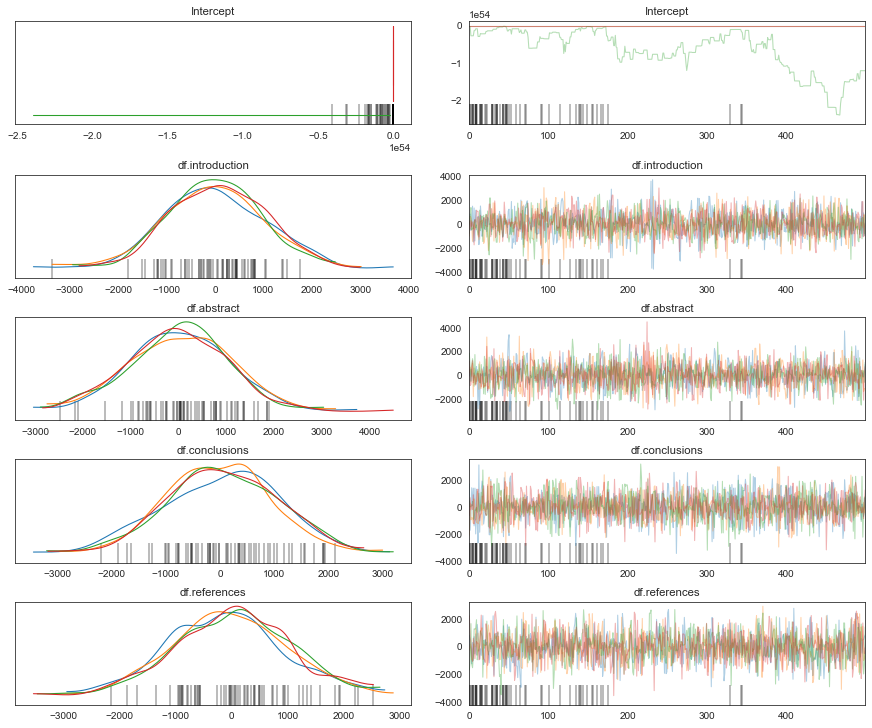

In [20]:
import arviz as az
az.plot_trace(trace)

In [21]:
pm.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Intercept,-1.648443e+53,4.005457e+53,-9.272732e+53,-3.948634e+33,1.596265e+53,1.185582e+53,6.0,6.0,4.0,11.0,3.55
df.introduction,1.023100e+01,1.017542e+03,-1.651110e+03,2.077143e+03,1.954700e+01,2.375100e+01,2710.0,918.0,2684.0,1641.0,1.00
df.abstract,1.420500e+01,1.038357e+03,-2.143993e+03,1.735153e+03,1.999300e+01,2.374900e+01,2697.0,956.0,2688.0,1718.0,1.01
df.conclusions,3.162800e+01,1.007535e+03,-1.816604e+03,1.924269e+03,1.788300e+01,2.438600e+01,3174.0,854.0,3150.0,1287.0,1.00
df.references,-1.827400e+01,1.023395e+03,-1.905679e+03,1.984552e+03,2.111100e+01,2.093700e+01,2350.0,1195.0,2317.0,1464.0,1.00


In [211]:
pdfText['abstract'].describe()

count    1304.000000
mean        0.009202
std         0.095524
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: abstract, dtype: float64

In [ ]:
## reference should be on the last or last two pages, the probability will be increased if we check based on the paper - group by file

In [212]:
pdfText['references'].describe()

count    1304.000000
mean        0.013804
std         0.116720
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: references, dtype: float64

In [35]:
import numpy as np 
import pandas as pd 
import statsmodels.api as sm
from statsmodels.tools import add_constant
from itertools import combinations
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

In [39]:
X = df.drop(["journal"], axis=1)
y = df["journal"]
# building the model and fitting the data 
ols_reg = sm.OLS(y, add_constant(X)).fit()
ols_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                journal   R-squared:                       0.287
Model:                            OLS   Adj. R-squared:                  0.258
Method:                 Least Squares   F-statistic:                     10.06
Date:                Tue, 03 Nov 2020   Prob (F-statistic):           7.00e-07
Time:                        17:15:12   Log-Likelihood:                 81.283
No. Observations:                 105   AIC:                            -152.6
Df Residuals:                     100   BIC:                            -139.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0232      0.012      1.909      0.059      -0.001       0.047
abstract         0.4311      0.317      1.359      0.177      -0.198       1.060
introduction     0.5081      0.232      2.187      0.031       0.047       0.969
biography     -9.75e-16   2.18e-16     -4.464      0.000   -1.41e-15   -5.42e-16
conclusions      1.8764      0.400      4.690      0.000       1.083       2.670
references       0.0577      0.155      0.371      0.711      -0.251       0.366
==============================================================================
Omnibus:                      104.203   Durbin-Watson:                   1.882
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1028.287
Skew:                           3.451   Prob(JB):                    5.13e-224
Kurtosis:                      16.689   Cond. No.                     5.92e+18
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is  3e-36. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

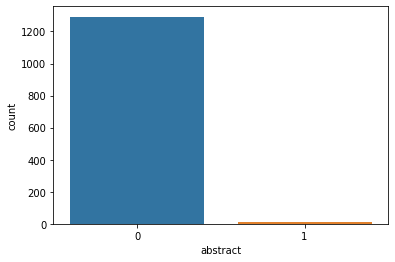

In [39]:
import seaborn as sns
ax = sns.countplot(x="abstract", data = pdfText)

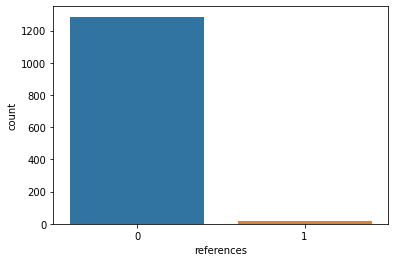

In [40]:
ax1 = sns.countplot(x="references", data = pdfText)

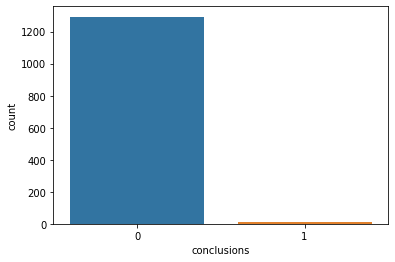

In [41]:
ax2 = sns.countplot(x="conclusions", data = pdfText)

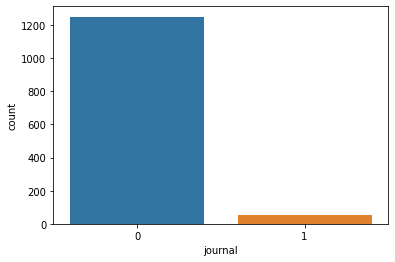

In [42]:
ax3 = sns.countplot(x="journal", data = pdfText)

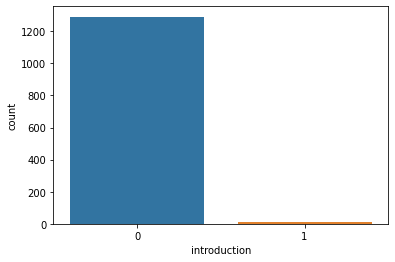

In [43]:
ax = sns.countplot(x="introduction", data = pdfText)

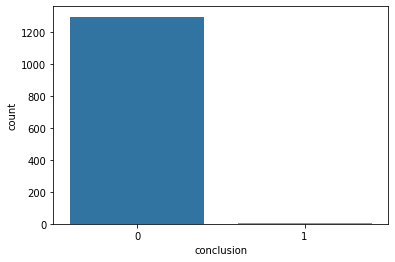

In [44]:
ax = sns.countplot(x="conclusion", data = pdfText)

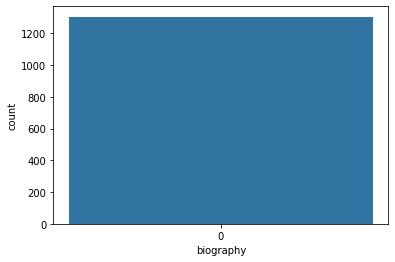

In [45]:
ax = sns.countplot(x="biography", data = pdfText)

In [50]:
from pandas_profiling import ProfileReport
profile = ProfileReport(pdfText, 
                        title='Pandas Profiling Report',
                        html={'style':{'full_width':True}},
                       minimal=True)
profile.to_notebook_iframe()